<a href="https://colab.research.google.com/github/F7FF/cap-comp215-max/blob/main/max_lab06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name: Max R
#### Date: March 5th, 2023

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [ ]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [ ]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = 'Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [ ]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2D_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [ ]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

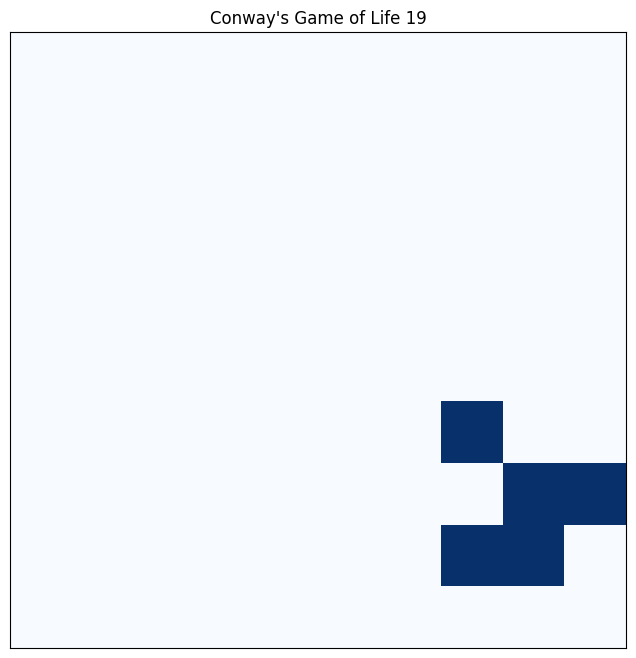

In [ ]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
 * how many unique states are there for a 3x3 (9 cell) neighbourhood?
 * how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
 * how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)
 * would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
 * propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
 * how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

In [ ]:
# Solutions for Ex. 1
"""
For a 9 cell neighborhood, there will be 2^9 possible states (512, I think), 
each with a corresponding 1 or a 0 (depending on whether that state should be alive or dead after)... 
so 2^2^9. Oh boy.

I like to use the approximation that 2^x is approximately 10^(3x/10) (ie. 2^10 is around a thousand, 2^20 is about a million, etc... very useful in hardware design!) 
which would put this at around 10^153 possible rules

Of course, if we're only talking about GoL style rules (where "A dead cell is made alive if it has between A and B neighbors alive, and a live cell is killed if it doesn't have between C and D neighbors alive") 
there are far far fewer - there are only 36 unique ranges from 0 to 8 (ie. only 36 sensible combinations of A and B in A <= x <= B),
so there are only 36^2 possible combinations of two ranges (the "killer" and "lifer" ranges) = 1296 possible rules.

If we tried to simulate all 10^153 basic 2D CA's... that's not happening. But simulating all 1296 possible range-based rules is very feasable, 
and one could fairly simply write a program that would check if one is "interesting" or not (maybe by checking sum and discarding nonsense ones)... or you could just blow a few hours on it for fun.

Using the 10^153 rule scheme, the GoL's rule number could be found by generating all possible 3x3 squares and finding the bit corresponding to whether the next cell will be 1 or 0... but I have a funny feeling that number would take a while to write.
Using the range method would be much easier, although slighly weird because we're talking about enumerating *ranges* not *bits*.

...I'm not sure why this is a written in a code cell, but hey!
"""
pass

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in lab 5

In [ ]:
# Solution for Ex. 2

class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        randomarray = np.random.rand(*self.state.shape)
        randomarray = randomarray < p

        self.state = np.zeros(self.state.shape, dtype=np.uint8)
        self.state[randomarray] = 1 #slight bodge but it works (use randomarray as a mask to assign 1)


def random_life(n_rows, n_cols=None, p=0.5):
    """ Return a Life2D object of given dimensions with initial randomized state where "live" cells have probability p """
    output = BetterLife2D(n_rows, n_cols)
    output.randomize_state(p)
    return output

foo = BetterLife2D(3)
foo.randomize_state(0.5)
foo.state

array([[1, 1, 1],
       [1, 1, 0],
       [0, 0, 1]], dtype=uint8)

### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

In [ ]:
# write code for your experiment here

def stabilizes_at(CA, maxstep): #returns the step # that the CA first stabilized at - ie. the first point at which CA.state equalled a previous state.
  states = list() #tried to use a set but ndarray can't be hashed - contains all past states
  for step in range(maxstep):
    states.append(CA.state)
    CA.step()
    for state in states: #cannot use 'in' or 'list.index()' to search states, so I gotta do it manually
      if(np.array_equal(state, CA.state)):
        return step
  return False #didn't stabilize before maxstep reached

results = []
for fiftyp in range(50): #DIVIDE ME BY 50 TO GET P BETWEEN 0 AND 1
  trialresults = []
  for trial in range(40): #40 trials at each p
    trialresults.append(stabilizes_at(random_life(20, p=fiftyp/50), 200))
  results.append(np.mean([x for x in trialresults if x])) #eliminate all false values

print(results)

#this might raise warnings if any of the trials do not have any stable patterns... I do not care

[nan, 1.05, 1.65, 2.948717948717949, 22.333333333333332, 37.7027027027027, 45.44117647058823, 50.54545454545455, 70.88888888888889, 94.72, 102.13636363636364, 87.82352941176471, 108.875, 102.10526315789474, 94.6, 87.75, 115.72, 100.25925925925925, 112.53846153846153, 114.46428571428571, 110.04761904761905, 94.36363636363636, 123.04, 99.84615384615384, 111.46666666666667, 106.5, 101.92307692307692, 102.94117647058823, 114.92592592592592, 110.22727272727273, 96.04347826086956, 75.58620689655173, 56.172413793103445, 53.705882352941174, 58.30555555555556, 24.64864864864865, 21.2, 12.162162162162161, 6.325, 13.15, 4.675, 1.925, 1.675, 1.4, 1.225, 1.175, 1.05, 1.0, 1.0, 1.0]


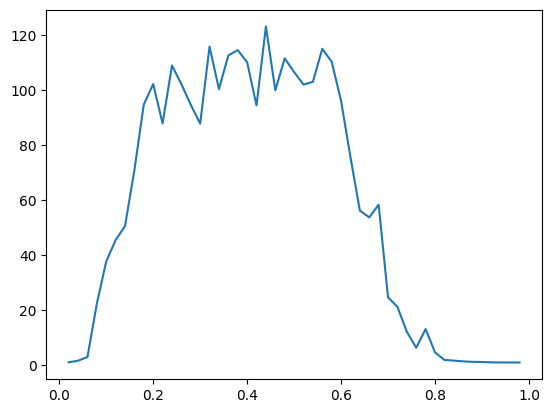

In [ ]:
plt.plot([x/50 for x in range(50)], results)

#...seems to show a rough bell curve, leaning towards 0...?

## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add an `load_pattern(x, y, pattern)` method to your BetterLife2D class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [ ]:
# Here's an example of the glider pattern from above defined in a single string...
glider_pattern = 
"""
010
001
111
"""

# Solution for Ex. 3

def pattern_to_array(pattern):
  patternlist = [x.split("") for x in pattern.split('\n')]
  #patternlist is now a 2d list of the whitespace-seperated rows in pattern
  return np.array(patternlist)

def _load_pattern(self, x, y, pattern):
  pass



BetterLife2D.load_pattern = _load_pattern

pattern_to_array(glider_pattern)

ValueError: ignored

### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

In [ ]:
# define your patterns here

### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

In [ ]:
# code for your experiment here